In [1]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 6c481a2ac79fd7758fe21f2539d3859f25edf78d
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [10]:
from MI_prediction.Utils.Datasets import  DataLoader_Rest, get_epochs, get_runs, get_labels
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from MI_prediction.Utils.Preprocess import filterbank_preprocessor, filterbank,FBCSP,moments
from MI_prediction.Utils.Windowers import create_windows
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV

from sklearn.preprocessing import StandardScaler
from mne.preprocessing import compute_current_source_density
from mne.time_frequency import psd_welch

import time
import pickle

# GIGAScience Cho2017

In [93]:
dl = DataLoader_Rest(dataset_name=Cho2017_Rest())

subjects = np.arange(1,53)
subjects = subjects[(subjects!=32) & (subjects!=46) & (subjects!=49)]

dl.load_data(subject_ids=[1])

In [94]:
duration = dl.dataset.datasets[0].raw.n_times/dl.dataset.datasets[0].raw.info['sfreq']

In [52]:
duration

66.5

## Moments

In [53]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)])

preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=1., h_freq=None)
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets, ed_offsets = create_windows(win = 2, start_offset = 5, end_offset = -5, mi_duration = 66, overlap = 0.5)

band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


In [5]:
ds_f = filterbank(dl, preprocess=preprocessors, filters=fb, channels_prep=Ch_prep)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)


/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 H

In [6]:
ds_f

In [38]:
trials = [tr.get_trials(start_offset=st_offsets, end_offset=ed_offsets) for tr in ds_f]

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

In [39]:
trials[0]['win_0'].description

,subject,session,run
0,1,session_0,run_0


In [40]:
nw = 0
epochs = [moments(get_epochs(epoch['win_'+str(nw)].split('session')['session_0'])) for epoch in trials]

In [41]:
plt.plot(epochs[0][0][0,:,:].T)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## PSD

In [95]:
fs = dl.dataset.datasets[0].raw.info['sfreq']

In [96]:
from copy import copy


preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        #Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=8., h_freq=30., method='iir',iir_params={'order':5,'ftype':'butter'}),
        #Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]
st_offsets, ed_offsets = create_windows(win = 55, start_offset = 5, end_offset = -6, mi_duration = 66, overlap = 0)

In [97]:
dl.preprocess_data(preprocessors=preprocessors)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



Effective window size : 2.000 (s)


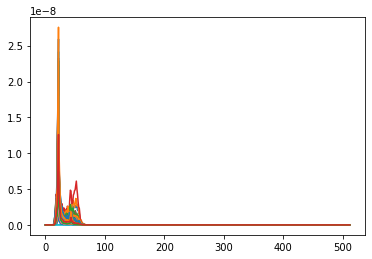

In [100]:
plt.plot(psd_welch(dl.dataset.datasets[0].raw,n_per_seg=int(2*fs),n_fft=1024)[0].T)
plt.show()

In [78]:
trials = dl.get_trials(start_offset=st_offsets, end_offset=ed_offsets)

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 28160 original time points ...
0 bad epochs dropped


In [79]:
get_epochs(trials['win_0'])[0].shape

(1, 64, 28160)

In [80]:
129*64

8256

In [81]:
trials = dl.get_trials(start_offset=st_offsets, end_offset=ed_offsets)

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 28160 original time points ...
0 bad epochs dropped


In [106]:
a = welch(get_epochs(trials['win_0'])[0],fs=fs,nperseg=int(2*fs))[-1]

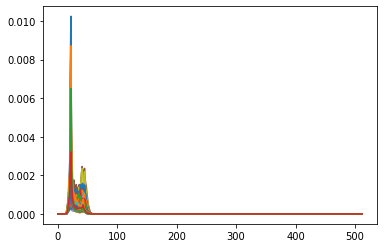

In [107]:
plt.plot(a[0,:,:].T)
plt.show()

In [41]:
a.shape

(64, 513)